# 환경 설정

In [ ]:
#@title 0. 로컬(colab) 한글 환경 설정
# 그래프에 한글을 표기하기 위한 설정 (폰트 설치 + ...)
# !sudo apt-get update -qq
# !sudo apt-get install -y fonts-nanum fonts-nanum-coding
# !sudo fc-cache -fv
# !rm -rf ~/.cache/matplotlib
# !rm -rf /tmp/.cache/matplotlib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
fonts-nanum-coding is already the newest version (2.5-3).
0 upgraded, 0 newly installed, 0 to remove and 57 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such 

# 데이터 수집


In [1]:
# @title svcKey
from dotenv import load_dotenv
import os

load_dotenv()

svcKey = os.getenv('ELECTRONIC_CAR_DATA')

In [2]:
#@title 1. API 데이터 수집 테스트
import requests

# url = 'https://apis.data.go.kr/B552584/EvCharger/getChargerInfo?serviceKey=여러분의_키&pageNo=1&numOfRows=10&zcode=26'
url = 'http://apis.data.go.kr/B552584/EvCharger/getChargerInfo'
# url = 'http://apis.data.go.kr/B552584/EvCharger/getChargerStatus'

BASE_URL = 'https://apis.data.go.kr/'
SERVICE_URL = 'B552584/EvCharger/getChargerInfo'

url = BASE_URL + SERVICE_URL

# svcKey는 decoding key (encoding 하지 않은 key라는 뜻에서 decoding key. 실제로 원래 키 -> 인코딩 -> 디코딩 은 아님); 환경설정에 기술
# svcKey = "tB...=="

params = {
    'serviceKey' : svcKey,
    'pageNo' : '1',
    'numOfRows' : '10',
    'zcode' : '26'
}  # zcode; 26=부산, 11=서울

response = requests.get(url, params=params)
print(response.content)

b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><header><resultCode>00</resultCode><resultMsg>NORMAL SERVICE.</resultMsg><totalCount>28309</totalCount><pageNo>1</pageNo><numOfRows>10</numOfRows></header><body><items><item><statNm>\xeb\xb6\x80\xec\x82\xb0 \xec\x96\xb4\xeb\xa6\xb0\xec\x9d\xb4 \xeb\x8c\x80\xea\xb3\xb5\xec\x9b\x90</statNm><statId>ME181207</statId><chgerId>01</chgerId><chgerType>06</chgerType><addr>\xeb\xb6\x80\xec\x82\xb0\xea\xb4\x91\xec\x97\xad\xec\x8b\x9c \xeb\xb6\x80\xec\x82\xb0\xec\xa7\x84\xea\xb5\xac \xec\x84\xb1\xec\xa7\x80\xea\xb3\xa1\xeb\xa1\x9c 3</addr><addrDetail>null</addrDetail><location>null</location><lat>35.1831134</lat><lng>129.0459801</lng><useTime>24\xec\x8b\x9c\xea\xb0\x84 \xec\x9d\xb4\xec\x9a\xa9\xea\xb0\x80\xeb\x8a\xa5</useTime><busiId>ME</busiId><bnm>\xed\x99\x98\xea\xb2\xbd\xeb\xb6\x80</bnm><busiNm>\xed\x99\x98\xea\xb2\xbd\xeb\xb6\x80</busiNm><busiCall>1661-9408</busiCall><stat>2</stat><statUpdDt>20251201192748</statUpdDt><lastTsdt

In [3]:
#@title 2. 데이터 가져오기 위한 준비_1
# zcode에 대해, pageNo, numOfRows 를 지정해서 데이터를 가져오는 API 밖에 정의되어 있지 않네...
import xml.etree.ElementTree as ET

# Update params for the initial request
params['pageNo'] = '1'
params['numOfRows'] = '9999'
params['zcode'] = '26'

# Make the API request
response = requests.get(url, params=params)

# Parse the XML response
root = ET.fromstring(response.content)

# Extract totalCount
total_count = int(root.find('header').find('totalCount').text)

# Extract all item elements
all_items = root.find('body').find('items').findall('item')

print(f"Total count for zcode=26: {total_count}")
print(f"Number of items in the first page (up to 9999): {len(all_items)}")

Total count for zcode=26: 28309
Number of items in the first page (up to 9999): 9999


In [4]:
#@title 3. 데이터 가져오기 위한 준비_2
# numOfRows를 최대치로 했는데 전부 못 가져왔으니, 나누어서 데이터를 가져와야겠네. 몇번에 나누어서 가져오면 좋을까?
import math

num_of_rows = int(params['numOfRows'])
total_pages = math.ceil(total_count / num_of_rows)

print(f"Total pages to retrieve all data for zcode=26: {total_pages}")

Total pages to retrieve all data for zcode=26: 3


In [5]:
#@title 4. 데이터 가져오기 (메인)
import time

# Initialize a list to hold all collected items
all_items = []

for page_no in range(1, total_pages + 1):
    params['pageNo'] = str(page_no)
    response = requests.get(url, params=params)
    root = ET.fromstring(response.content)

    # Check if 'items' tag exists before trying to find 'item' elements
    items_element = root.find('body').find('items')
    if items_element is not None:
        all_items.extend(items_element.findall('item'))
    else:
        print(f"No items found on page {page_no}")

    # Introduce a small delay to avoid overwhelming the API server
    time.sleep(0.5)

print(f"Total items collected across all pages for zcode=26: {len(all_items)}")
# print(all_items.head())
print(all_items[:5]) # Added: To show the first 5 elements of the list

Total items collected across all pages for zcode=26: 28309
[<Element 'item' at 0x7183403e4130>, <Element 'item' at 0x71831b392b60>, <Element 'item' at 0x71831b393740>, <Element 'item' at 0x71831b3a0360>, <Element 'item' at 0x71831b3a0f40>]


In [6]:
#@title 5. 데이터 수집 확인
import pandas as pd

# Prepare a list to hold dictionaries of item data
data = []

# Iterate through each item element and extract relevant information
for item in all_items:
    item_data = {}
    for child in item:
        item_data[child.tag] = child.text
    data.append(item_data)

# Create a pandas DataFrame from the list of dictionaries
df = pd.DataFrame(data)
df[:5]

,statNm,statId,chgerId,chgerType,addr,addrDetail,location,lat,lng,useTime,...,note,limitYn,limitDetail,delYn,delDetail,trafficYn,year,floorNum,floorType,maker
0,부산 어린이 대공원,ME181207,01,06,부산광역시 부산진구 성지곡로 3,null,null,35.1831134,129.0459801,24시간 이용가능,...,None,N,None,N,None,N,2018,1,F,시그넷
1,부산시 교육청,ME181208,01,06,부산광역시 부산진구 화지로 12,null,null,35.1761301,129.0639265,24시간 이용가능,...,None,N,None,N,None,N,2018,1,F,시그넷
2,부산아시아드보조경기장VIP주차장,ME181210,01,06,부산광역시 연제구 거제동 1312,null,null,35.1883518,129.0555415,05:00~24:00,...,None,N,None,N,None,N,2018,1,F,시그넷
3,부산아시아드보조경기장VIP주차장,ME181210,02,06,부산광역시 연제구 거제동 1312,null,null,35.1883518,129.0555415,05:00~24:00,...,None,N,None,N,None,N,2018,1,F,시그넷
4,부산아시아드보조경기장VIP주차장,ME181210,11,04,부산광역시 연제구 거제동 1312,null,null,35.1883518,129.0555415,05:00~24:00,...,None,N,None,N,None,N,2018,1,F,시그넷


# 데이터 탐색

In [7]:
#@title 1. 데이터 기본 정보 확인
# 데이터 샘플 확인
# print(df.head())
# print(df.tail())

# 전체 컬럼과 타입, 결측치 확인
print(df.info())

# 행/열 개수
# print(df.shape)
# print(df.count())

# 각 컬럼의 데이터 타입
# print(df.dtypes)

# 데이터 구조 파악
# print(df.columns)
# print(df.index)
# print(df.values)

# # 특정 조건의 데이터 샘플 확인; dtype이 object인 컬럼의 값을 정렬해서 출력하고 갯수를 표시
# columns_object_dtype = df.columns[df.dtypes=='object']
# # print(columns_object_dtype)
# for col in columns_object_dtype:
#     # print (sorted(df[col].unique()))
#     # unique_values = sorted(df[col].unique())
#     unique_values = df[col].unique()
#     print(f'{col}: {len(unique_values)}개')
#     print(unique_values, '\n')

# colab의 cell 안에서 모든 컬럼을 다 표시하기 위한 설정
# pd.set_option('display.max_columns', None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28309 entries, 0 to 28308
Data columns (total 37 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   statNm       28309 non-null  object
 1   statId       28309 non-null  object
 2   chgerId      28309 non-null  object
 3   chgerType    28309 non-null  object
 4   addr         28309 non-null  object
 5   addrDetail   28309 non-null  object
 6   location     28309 non-null  object
 7   lat          28309 non-null  object
 8   lng          28309 non-null  object
 9   useTime      28105 non-null  object
 10  busiId       28309 non-null  object
 11  bnm          28309 non-null  object
 12  busiNm       28309 non-null  object
 13  busiCall     28309 non-null  object
 14  stat         28309 non-null  object
 15  statUpdDt    28182 non-null  object
 16  lastTsdt     25607 non-null  object
 17  lastTedt     25718 non-null  object
 18  nowTsdt      4822 non-null   object
 19  powerType    0 non-null  

In [ ]:
#@title 2. 결측치 탐색
# 컬럼별 결측치 개수; R에선 NA(not available) = 결측값(알 수 없음) vs. NULL = 빈 객체. 존재하지 않음.
# print(df.isnull().sum())
# print(df.isna().sum())  # 공식 권장

# 결측치 아닌 값 찾기
# print(df.notnull())

# 특정 컬럼의 결측행 조회
# print(df[df['useTime'].isnull()])

# # 컬럼명으로 누락 분석
# missing_cols = df.columns[df.isnull().sum() > 0]
# print("누락 컬럼:", list(missing_cols))
# # ['useTime', 'statUpdDt', 'powerType', ...]

# 결측치 삭제/대체
# print(df.dropna())
# print(df.fillna(0))

In [8]:
#@title 3. 기본 통계 및 분포
# 수치형 기본 통계(카운트, 평균, 표준편차, 최소, 25%, 중앙, 75%, 최대)
# print(df.describe())

# 범주형 통계(최빈값 top, 개수 unique, 빈도 freq)
# print(df.describe(include='all'))

# 범주형 데이터 빈도
print(df['maker'].value_counts())

# 고유값/개수
print(df['maker'].unique())
print(df['maker'].nunique())

maker
클린일렉스        1929
시그넷          1889
한국알박         1805
에바           1749
LS산전         1178
중앙제어         1083
채비            826
에버온           634
휴맥스이브이        566
스타코프          558
이카플러그         318
LS전선          272
모던텍           159
매니지온          117
블루네트웍스        105
PNE            73
씨어스            62
KLIN ELEX      55
보타리에너지         34
피에스텍           26
차지인            25
옴니시스템          22
남부산전           20
가가전력           13
주식회사AFT        12
대경엔지니어링        11
스필             10
피앤씨주식회사         6
피에스엔            5
애플망고            3
Name: count, dtype: int64
['시그넷' '채비' '중앙제어' None '모던텍' '블루네트웍스' '에바' '보타리에너지' '클린일렉스' '휴맥스이브이'
 '씨어스' '이카플러그' '스필' '한국알박' '에버온' 'PNE' '차지인' 'LS전선' 'LS산전' 'KLIN ELEX'
 '주식회사AFT' '대경엔지니어링' '가가전력' '피에스텍' '피에스엔' '옴니시스템' '남부산전' '매니지온' '스타코프'
 '애플망고' '피앤씨주식회사']
30


In [9]:
# @title 3.1 범주형과 수치형
import numpy as np
import pandas as pd

numeric_cols = []
df_copy = df.copy()  # 원본 유지

for col in df.columns:
    # 숫자 변환 시도, 실패 시 NaN으로 처리
    converted = pd.to_numeric(df[col], errors='coerce')
    non_null_ratio = converted.notnull().mean()

    # 90% 이상 숫자면 수치형 컬럼으로 판단
    if non_null_ratio > 0.9:
        df_copy[col] = converted
        numeric_cols.append(col)

object_cols = [c for c in df.columns if c not in numeric_cols]

print(f"📈 수치형 컬럼: {len(numeric_cols)}개")
print(numeric_cols)

print(f"\n📝 범주형 컬럼: {len(object_cols)}개")
print(object_cols)

# 변환 후 통계
print("\n📊 수치형 통계:")
print(df_copy[numeric_cols].describe())

📈 수치형 컬럼: 13개
['chgerId', 'chgerType', 'lat', 'lng', 'stat', 'statUpdDt', 'lastTsdt', 'lastTedt', 'output', 'zcode', 'zscode', 'year', 'floorNum']

📝 범주형 컬럼: 24개
['statNm', 'statId', 'addr', 'addrDetail', 'location', 'useTime', 'busiId', 'bnm', 'busiNm', 'busiCall', 'nowTsdt', 'powerType', 'method', 'kind', 'kindDetail', 'parkingFree', 'note', 'limitYn', 'limitDetail', 'delYn', 'delDetail', 'trafficYn', 'floorType', 'maker']

📊 수치형 통계:
            chgerId     chgerType           lat           lng          stat  \
count  28309.000000  28309.000000  28309.000000  28309.000000  28309.000000   
mean      11.579533      2.182627     35.174034    129.068770      2.349430   
std       16.701485      0.689293      0.086026      0.110257      1.163743   
min        0.000000      1.000000     34.700000    126.648000      1.000000   
25%        2.000000      2.000000     35.137376    129.016220      2.000000   
50%        5.000000      2.000000     35.169571    129.078925      2.000000   
75%    

In [13]:
from matplotlib import font_manager

# 시스템에 설치된 모든 폰트 확인
for font in font_manager.findSystemFonts(fontpaths=['/usr/share/fonts/opentype/noto']):
    print(font_manager.FontProperties(fname=font).get_name())

Noto Serif CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Noto Sans CJK JP
Noto Serif CJK JP
Noto Sans CJK JP
Noto Serif CJK JP
Noto Serif CJK JP
Noto Serif CJK JP
Noto Serif CJK JP
Noto Serif CJK JP
Noto Sans CJK JP
Noto Sans CJK JP


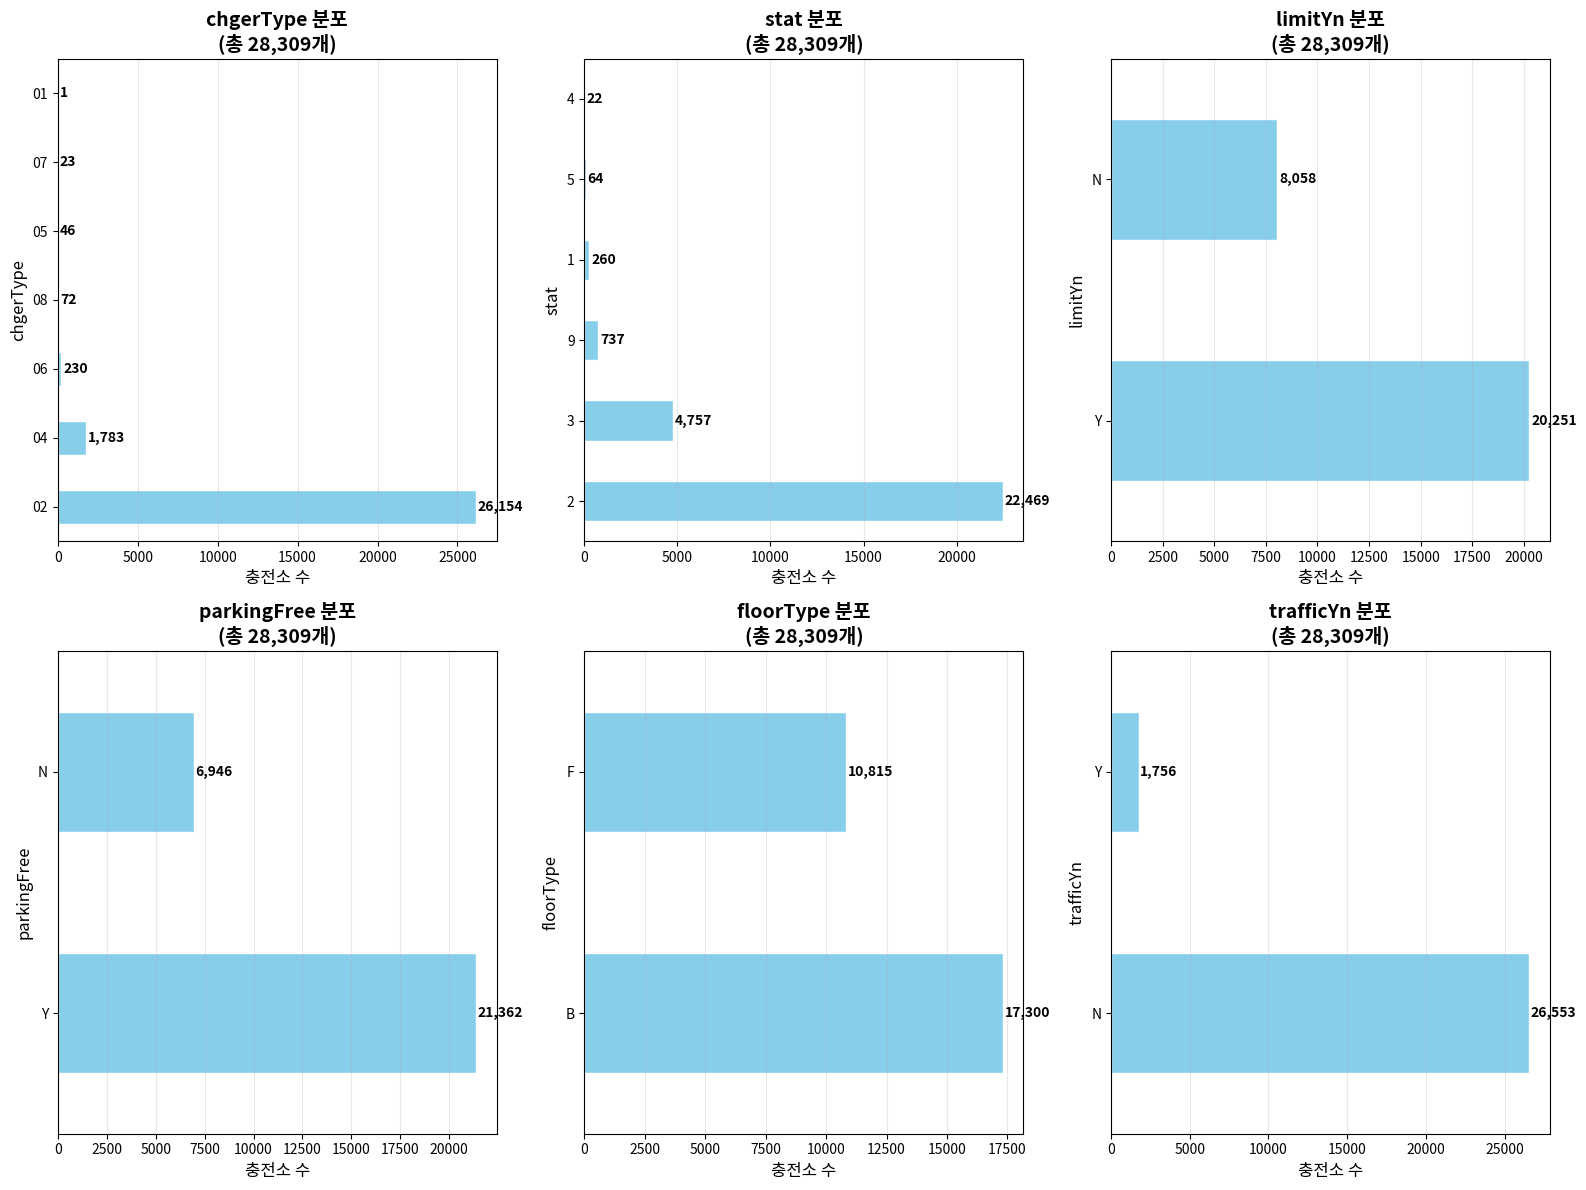

In [14]:
# @title 3.2 가시화
# 1. 한글 폰트 설정
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# 'NanumBarunGothic' 폰트가 시스템에 정상적으로 등록되었는지 확인 후 사용
# 폰트명은 설치된 폰트 목록에서 정확하게 확인해야 합니다.
plt.rc('font', family='Noto Sans CJK JP')  # 한글 폰트
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 2. 서브플롯 생성
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
axes = axes.flatten()

# 3. 핵심 6개 컬럼 빈도 분석
top_cols = ['chgerType', 'stat', 'limitYn', 'parkingFree', 'floorType', 'trafficYn']

for i, col in enumerate(top_cols):
    if col in df.columns:
        # value_counts로 빈도 계산
        vc = df[col].value_counts()
        bars = vc.plot(kind='barh', ax=axes[i], color='skyblue', edgecolor='white')

        # 제목 (한글!)
        axes[i].set_title(f'{col} 분포\n(총 {len(df):,}개)', fontweight='bold', fontsize=14)
        axes[i].set_xlabel('충전소 수', fontsize=12)
        axes[i].set_ylabel(col, fontsize=12)

        # 숫자 라벨 추가
        for idx, (value, count) in enumerate(vc.items()):
            axes[i].text(count + 100, idx, f'{count:,}',
                        va='center', fontweight='bold', fontsize=10)

        # 그리드 추가
        axes[i].grid(axis='x', alpha=0.3)

# 4. 빈 서브플롯 숨기기 (6개 딱 맞음)
plt.tight_layout()
plt.show()

인코딩된 범주들:
{'01': 0, '02': 1, '04': 2, '05': 3, '06': 4, '07': 5, '08': 6}


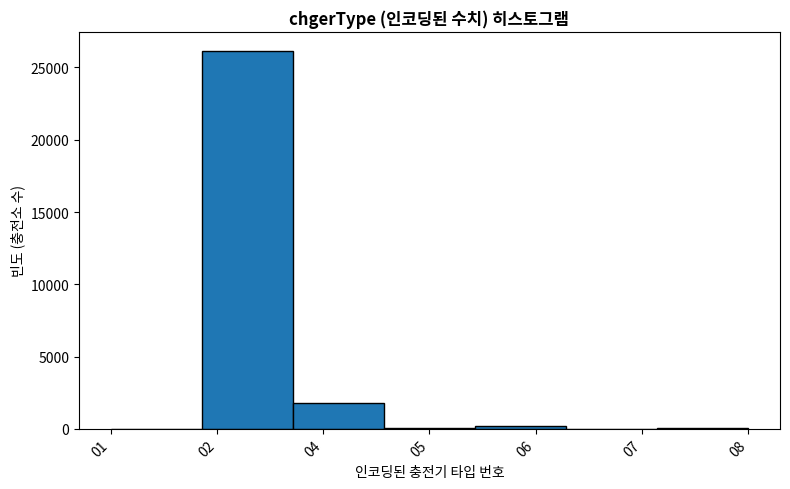

In [15]:
#@title 3.3 가시화 2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 수치형 컬럼: 13개
# ['chgerId', 'chgerType', 'lat', 'lng', 'stat', 'statUpdDt', 'lastTsdt', 'lastTedt', 'output', 'zcode', 'zscode', 'year', 'floorNum']

# 범주형 컬럼: 24개
# ['statNm', 'statId', 'addr', 'addrDetail', 'location', 'useTime', 'busiId', 'bnm', 'busiNm', 'busiCall', 'nowTsdt', 'powerType', 'method', 'kind', 'kindDetail', 'parkingFree', 'note', 'limitYn', 'limitDetail', 'delYn', 'delDetail', 'trafficYn', 'floorType', 'maker']

col = 'chgerType'
# LabelEncoder 객체 생성
le = LabelEncoder()

# 컬럼을 인코딩하고 새로운 컬럼 생성
df['chgerType_encoded'] = le.fit_transform(df[col])

print("인코딩된 범주들:")
# 인코딩된 결과 확인:
# le.classes_는 ['AC 단상', 'DC 차데모', 'DC 콤보', ...] 순서로 저장되어 있고,
# 이들이 0, 1, 2... 순으로 매핑됨
print(dict(zip(le.classes_, range(len(le.classes_)))))

# # 폰트 설정 (이전 단계에서 런타임 재시작 후 설정되었다고 가정)
# plt.rc('font', family='NanumBarunGothic')
# plt.rcParams['axes.unicode_minus'] = False

# 인코딩된 수치를 사용하여 히스토그램 그리기
plt.figure(figsize=(8, 5))
df['chgerType_encoded'].plot.hist(bins=len(le.classes_), edgecolor='black')

# 그래프 제목 및 축 이름 설정
plt.title(f'{col} (인코딩된 수치) 히스토그램', fontweight='bold')
plt.xlabel('인코딩된 충전기 타입 번호')
plt.ylabel('빈도 (충전소 수)')

# 팁: x축의 눈금을 실제 타입으로 변경하여 가독성을 높일 수 있습니다.
plt.xticks(ticks=range(len(le.classes_)), labels=le.classes_, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
#@title 4. 데이터 분포 및 이상치

# # 박스플롯(이상치)
# print(df[col].plot.box())
# print(df[col].plot.bar())

# # 커널 밀도 추정; x값 주변에 데이터가 얼마나 존재하는가(나올 가능성이 얼마나 높은가)를 나타내는 값
# print(df['col'].plot.kde())

# sns.boxplot(x='col', data=df)
# sns.histplot(data=df, x='col')


In [16]:
#@title 5. 상관 관계/요약/집계
print(df.corr())
sns.heatmap(df.corr())

# 그룹별 집계
print(df.groupby('col').mean())
print(df.groupby('col').size())

# pivot
df.pivot_table(values='매출', index='월', columns='점포', aggfunc='mean')

# 교차표
df.crosstab(df['colA'], df['colB'])

ValueError: could not convert string to float: '부산 어린이 대공원'

In [ ]:
#@title 6. 필터링/정렬/변환/리포팅
# 조건 필터
print(df[df['chgerType'] == '06'])

# 정렬
# print(df.sort_values(by='col', ascending=False))

# 데이터 변환/새 컬럼 추가
# df['col'].map({…})
# df.apply()
# df.assign()

# !pip install ydata_profiling
# 자동 리포트/요약 툴
# from ydata_profiling import ProfileReport  # EDA 자동화 라이브러리
# profile = ProfileReport(df, title="Titanic EDA 리포트", explorative=True)  # df에 대한 요약 리포트 객체 생성; 처리 시간 긺
# profile_minimal = ProfileReport(df, title="Titanic Minimal EDA 리포트", minimal=True)
# profile_minimal.to_file('titanic_minimal_EDA.html')


                  statNm    statId chgerId chgerType                    addr  \
0             부산 어린이 대공원  ME181207      01        06       부산광역시 부산진구 성지곡로 3   
1                부산시 교육청  ME181208      01        06       부산광역시 부산진구 화지로 12   
2      부산아시아드보조경기장VIP주차장  ME181210      01        06      부산광역시 연제구 거제동 1312   
3      부산아시아드보조경기장VIP주차장  ME181210      02        06      부산광역시 연제구 거제동 1312   
8               롯데마트 광복점  ME181225      01        06  부산광역시 중구 중앙대로2 (중앙동7가)   
...                  ...       ...     ...       ...                     ...   
28294             부산환경공단  TS262901      01        06      부산광역시 남구 이기대공원로 11   
28295             부산환경공단  TS262901      02        06      부산광역시 남구 이기대공원로 11   
28296             부산환경공단  TS262901      03        06      부산광역시 남구 이기대공원로 11   
28297             부산환경공단  TS262901      04        06      부산광역시 남구 이기대공원로 11   
28298      부산 신평장림혁신지원센터  TS263808      01        06   부산광역시 사하구 다대로1066번길 9   

      addrDetail location         lat  